In [25]:
from itertools import permutations as perms
from itertools import product
import numpy as np
import MultiPoint as mp
import propagator 

In [2]:
%matplotlib inline
import mpld3
import matplotlib.pyplot as plt
mpld3.enable_notebook()
import numpy as np

In [3]:
class phi_tilde:    
    def __init__(self,k,alpha=0,l=0,m=0):
        self.k=k
        self.alpha=alpha
        self.l=l
        self.m=m

In [4]:
def plotlog(x, y, alpha, xrange=1, numx=2):
    xv = np.logspace(np.log10(x), np.log10(x) + xrange, numx)
    C = y / (x**alpha)
    yv = C * xv**(alpha)
    plt.loglog(xv, yv)

In [5]:
def norm(K):
    return np.linalg.norm(K)

## Two point correlations

In [6]:
def I2N(N, fa, p1, sequence):
    lam0=0
    lam=0
    
    if sequence == (0,0): # AA
        value = mp.IAAresum(N,fa,lam0,lam,p1)
    elif sequence ==(0,1): # AB
        value = mp.IABresum(N,fa,lam0,lam,p1)
    elif sequence == (1,1): # BB
        value = mp.IAAresum(N,1-fa,lam0,lam,p1)
    else:
        value=0.0
    return value

In [7]:
def twoPointCorr(pset,N,fa,phi1,phi2):
    val = 0.0+0.0j
    for ordered in perms([phi1,phi2]):
        q1=-ordered[0].k

        # chemical sequence, A is 1
        sequence = (ordered[0].alpha,ordered[1].alpha)

        # Calculate or look up eigenstuff
        p = pset.get_vec_prop(q1)
        val += I2N(N, fa, p.prop(0), sequence)
    return val

In [8]:
def s2wlc(pset, N, fa, K):
    s2 = np.zeros((2,2),dtype=type(1+1j))
    k1=np.array([0,0,1])*K
    k2=-k1

    for a1 in [0,1]:
        for a2 in [0,1]:
            phi1 = phi_tilde(k1,alpha=a1)
            phi2 = phi_tilde(k2,alpha=a2)
            s2[a1][a2] = twoPointCorr(pset, N, fa, phi1, phi2)
    return s2

In [9]:
def s2inverse(pset, N, fa, K):
    s2 = s2wlc(pset, N, fa, K)
    s2inv = np.zeros((2,2),dtype=type(1+1j))
    
    [s2aa, s2ab], [s2ba, s2bb] = s2
    det = s2aa*s2bb - s2ab*s2ba
    
    s2inv[0,0] = s2bb/det
    s2inv[0,1] = -s2ab/det
    s2inv[1,0] = -s2ba/det
    s2inv[1,1] = s2bb/det
    
    return s2inv

In [10]:
N=10
fa=0.5

nlam=4
pset=propagator.prop_set(nlam=nlam)

# K = 10
# s2wlc(pset, N, fa, K)

KV = np.logspace(-1,3,10)
s2 = np.zeros((2,2,len(KV)),dtype=type(1+1j))
for ind, K in enumerate(KV):
    s2[:,:,ind] = s2wlc(pset, N, fa, K)/(N**2)

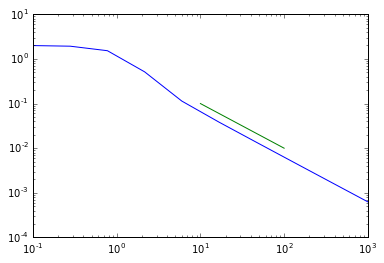

In [15]:
plt.loglog(KV, np.real(np.sum(np.vstack([s2[0,0,:], s2[0,1,:], \
                                         s2[1,0,:], s2[1,1,:]]), axis=0)))
plotlog(1e1,1e-1,-1)
plt.show()

## Three point correlations

In [37]:
def I3N(N,fa,lam0_1,lam_1,mu1,\
            lam0_2,lam_2,mu2,\
            p1,p2,\
            sequence):
    
    value = 0
    if sequence == (0,0,0): # AAAA
        value = mp.IAAAresum(N,fa,lam0_1,lam_1,\
                                  lam0_2,lam_2,\
                                  p1.prop(mu1),\
                                  p2.prop(mu2))
    elif sequence == (0,0,1): # AAB
        value = mp.IABBresum(N,1-fa,lam0_1,lam_1,\
                                  lam0_2,lam_2,\
                                  p1.prop(mu1),\
                                  p2.prop(mu2))
    elif sequence == (0,1,1): # ABB
        value = mp.IABBresum(N,fa,lam0_1,lam_1,\
                                  lam0_2,lam_2,\
                                  p1.prop(mu1),\
                                  p2.prop(mu2))
    elif sequence == (1,1,1): # BBB
        fb=1.0-fa
        # Same as AAAA except fb instead of fa
        value = mp.IAAAresum(N,fb,lam0_1,lam_1,\
                                  lam0_2,lam_2,\
                                  p1.prop(mu1),\
                                  p2.prop(mu2))
    else:
        pass
    
    return value

### Space ordering of wavevectors

In [44]:
# Inputs
#     pset (propagator.prop_set), the set of propagators used so far
#     N (float), number of Khun lengths
#     fa (float), fraction of type A
#     prop1 (phi_tilde), contains k and alpha
def threePointCorr(pset,N,fa,phi1,phi2,phi3):
#     print('Warning: Winger D hasnt been implemented!')
    nlam=pset.nlam
    # The first and last lam must be zero 
    mu1=0
    mu2=0
    lam0_1=0
    lam_2=0
    
    total = 0.0+0.0j
    # The Points can be visited in any order
    for ordered in perms([phi1,phi2,phi3]):
        # while phi1.k is the absolute Fourier position
        # q1 is the relitive Fourier position of 1 and 2
        q1=-ordered[0].k
        q2=-ordered[0].k-ordered[1].k

        # chemical sequence, A is 1
        sequence = (ordered[0].alpha,ordered[1].alpha,ordered[2].alpha)
        
        # Calculate or look up eigenstuff
        p1 = pset.get_vec_prop(q1)
        p2 = pset.get_vec_prop(q2)

        # Angular sum
        for lam in range(0,nlam):
            lam_1, lam0_2 = lam, lam
            value = I3N(N,fa,lam0_1,lam_1,mu1,\
                        lam0_2,lam_2,mu2,\
                        p1,p2,\
                        sequence)

            # Wigner D goes here!

            total = total + value
    return total

In [45]:
def s3wlc(pset, N, fa, Ks):
    s3 = np.zeros((2,2,2),dtype=type(1+1j))
    k1, k2, k3 = Ks
    if norm(k1+k2+k3) >= 1e-10:
        raise('Qs must add up to zero')

    for a1, a2, a3 in product([0,1], repeat=3):
        phi1 = phi_tilde(k1,alpha=a1)
        phi2 = phi_tilde(k2,alpha=a2)
        phi3 = phi_tilde(k3,alpha=a3)

        s3[a1][a2][a3] = threePointCorr(pset, N, fa, \
                                       phi1, phi2, phi3)
    return s3

In [62]:
N=0.1
fa=1.0

def setKs(K):
    k1=np.array([0,0,1])*K
    k2=np.array([0,0,1])*K
    k3=-k1-k2

    Ks = [k1, k2, k3]
    return Ks

nlam=6
pset=propagator.prop_set(nlam=nlam)

# K = 10.0
# Ks = setKs(K)
# s3wlc(pset, N, fa, Ks)

KV = np.logspace(0,5,10)
s3 = np.zeros((2,2,2,len(KV)),dtype=type(1+1j))
for ind, K in enumerate(KV):
    k = setKs(K)
    s3[:,:,:,ind] = s3wlc(pset, N, fa, k)/(N**3)

ValueError: Data has no positive values, and therefore can not be log-scaled.

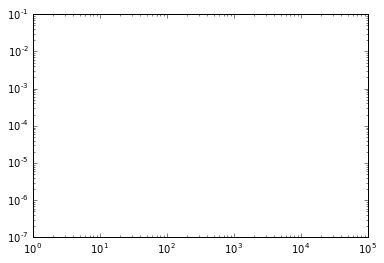

In [64]:
plt.loglog(KV, s3[0,0,0,:])
plotlog(1e1, 5e-3, -2, xrange=2)
plt.show()

## Four point correlations

\begin{align*}
\underset{\alpha_{1}\alpha_{2}\alpha_{3}\alpha_{4}}{I_{1,2,3}^{\left(4\right)}\left(N\right)}= & \int_{0}^{N}ds_{3}\int_{0}^{s_{4}}ds_{2}\int_{0}^{s_{3}}ds_{1}\int_{0}^{s_{1}}ds_{0}\delta_{\alpha\left(s_{1}\right),\alpha_{1}}\delta_{\alpha\left(s_{2}\right),\alpha_{2}}\delta_{\alpha\left(s_{3}\right),\alpha_{3}}\delta_{\alpha\left(s_{4}\right),\alpha_{4}}\\
 & \cdot\mathcal{G}_{\lambda0_{1}\lambda_{1}}^{\mu_{1}}\left(s_{4}-s_{3},K_{1}\right)\mathcal{G}_{\lambda0_{2}\lambda_{2}}^{\mu_{2}}\left(s_{3}-s_{2},K_{2}\right)\mathcal{G}_{\lambda0_{3}\lambda_{3}}^{\mu_{3}}\left(s_{2}-s_{1},K_{2}\right)
\end{align*}

In [185]:
def I4N(N,fa,lam0_1,lam_1,mu1,\
           lam0_2,lam_2,mu2,\
           lam0_3,lam_3,mu3,\
           p1,p2,p3,\
           sequence):
    
    value = 0
    if sequence == (0,0,0,0): # AAAA
        value = mp.IAAAAresum(N,fa,lam0_1,lam_1,\
                                   lam0_2,lam_2,\
                                   lam0_3,lam_3,\
                                   p1.prop(mu1),\
                                   p2.prop(mu2),\
                                   p3.prop(mu3))
    elif sequence == (0,0,0,1): # AAAB
        value = mp.IAAABresum(N,fa,lam0_1,lam_1,\
                                   lam0_2,lam_2,\
                                   lam0_3,lam_3,\
                                   p1.prop(mu1),\
                                   p2.prop(mu2),\
                                   p3.prop(mu3))   
    elif sequence == (0,0,1,1): # AABB
        value = mp.IAABBresum(N,fa,lam0_1,lam_1,\
                                   lam0_2,lam_2,\
                                   lam0_3,lam_3,\
                                   p1.prop(mu1),\
                                   p2.prop(mu2),\
                                   p3.prop(mu3))
    elif sequence == (0,1,1,1): # ABBB
        fb=1.0-fa
        # Same as AAAB except fb instead of fa
        value = mp.IAAABresum(N,fb,lam0_1,lam_1,\
                                   lam0_2,lam_2,\
                                   lam0_3,lam_3,\
                                   p1.prop(mu1),\
                                   p2.prop(mu2),\
                                   p3.prop(mu3))
    elif sequence == (1,1,1,1): # BBBB
        fb=1.0-fa
        # Same as AAAA except fb instead of fa
        value = mp.IAAAAresum(N,fb,lam0_1,lam_1,\
                                   lam0_2,lam_2,\
                                   lam0_3,lam_3,\
                                   p1.prop(mu1),\
                                   p2.prop(mu2),\
                                   p3.prop(mu3))
    else:
        pass
    
    return value

### Space ordering of wavevectors

$\textbf{fourPointCorr}$ calculates $\int_0^N d^4s\left\langle \tilde{\psi}_{1}\tilde{\psi}_{2}\tilde{\psi}_{3}\tilde{\psi}_{3}\right\rangle $.
The $\psi$s are not orientation dependent. This will change when
I introduce Maier-Saupe interaction.
The average is over the unperturbed distribution of a single WLC that
is N segments long with $f_{A}$ being of A type.
Each $\tilde{\psi}$ has an associated chemical identity, $\alpha$, and Fourier location, $\vec{k}$.

In [207]:
# Inputs
#     pset (propagator.prop_set), the set of propagators used so far
#     N (float), number of Khun lengths
#     fa (float), fraction of type A
#     prop1 (phi_tilde), contains k and alpha
def fourPointCorr(pset,N,fa,phi1,phi2,phi3,phi4):
    print('Warning: Winger D hasnt been implemented!')
    nlam=pset.nlam
    # The first and last lam must be zero 
    mu1=0 
    mu3=0
    lam0_1=0
    lam_3=0
    
    total = 0.0+0.0j
    # The Points can be visited in any order
    for ordered in perms([phi1,phi2,phi3,phi4]):
        # while phi1.k is the absolute Fourier position
        # q1 is the relitive Fourier position of 1 and 2
        q1=-ordered[0].k
        q2=-ordered[0].k-ordered[1].k
        q3=-ordered[0].k-ordered[1].k-ordered[2].k

        # chemical sequence, A is 1
        sequence = (ordered[0].alpha,ordered[1].alpha,\
                    ordered[2].alpha,ordered[3].alpha)
        
        # Calculate or look up eigenstuff
        p1 = pset.get_vec_prop(q1)
        p2 = pset.get_vec_prop(q2)
        p3 = pset.get_vec_prop(q3)

        # Angular sum
        for lam_1 in range(0,nlam):
            for lam_2 in range(0,nlam):
                for mu2 in range(-min(lam_2,lam_3),\
                                 min(lam_2,lam_3)+1): 
                    lam0_2=lam_1
                    lam0_3=lam_2
                    
                    value=I4N(N,fa,lam0_1,lam_1,mu1,\
                               lam0_2,lam_2,mu2,\
                               lam0_3,lam_3,mu3,\
                               p1,p2,p3,\
                               sequence) 
                        
                    # Wigner D goes here!
                    
                    total = total + value
    return total

In [213]:
def s4wlc(pset, N, fa, Ks):
    s4 = np.zeros((2,2,2,2),dtype=type(1+1j))
    k1, k2, k3, k4 = Ks
    if norm(K1+K2+K3+K4) >= 1e-10:
        raise('Qs must add up to zero')

    for a1, a2, a3, a4 in product([0,1], repeat=4):
        phi1 = phi_tilde(k1,alpha=a1)
        phi2 = phi_tilde(k2,alpha=a2)
        phi3 = phi_tilde(k3,alpha=a3)
        phi4 = phi_tilde(k4,alpha=a4)

        s4[a1][a2][a3][a4] = fourPointCorr(pset, N, fa, \
                                           phi1, phi2, phi3, phi4)
    return s4

In [219]:
# N=0.1
# fa=0.345890

# def setKs(K):
#     k1=np.array([0,0,1])*K
#     k2=np.array([0,0,1])*K
#     k3=-k2
#     k4=-k3

#     k = [k1, k2, k3, k4]
#     return k

# nlam=4
# pset=propagator.prop_set(nlam=nlam)

# # K = 10.0
# # k = setKs(K)
# # s4wlc(pset, N, fa, k)

# KV = np.logspace(-1,3,10)
# s4 = np.zeros((2,2,2,2,len(KV)),dtype=type(1+1j))
# for ind, K in enumerate(KV):
#     k = setKs(K)
#     s4[:,:,:,:,ind] = s4wlc(pset, N, fa, k)/(N**4)

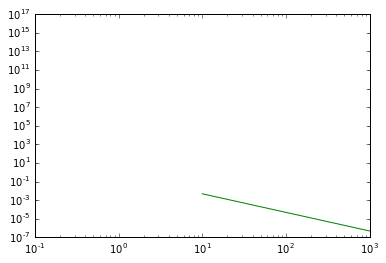

In [209]:
# plt.loglog(KV, s4[0,0,0,0,:])
# plotlog(1e1, 5e-3, -2, xrange=2)
# plt.show()

## Rigid rod limit structure factor

Consider the special case that the four wavevectors form a straight line.

The structure factor of a rigid rod after rotation average is
\begin{eqnarray}
I_4 = 
\int_{0}^{L} ds_1
\int_{0}^{L} ds_2
\int_{0}^{L} ds_3
\int_{0}^{L} ds_4
\frac{\sin{kL(s_1 + s_2 - s_3 - s_4)}}
{kL(s_1 + s_2 - s_3 - s_4)}
\end{eqnarray}